In [1]:
import torch, os
torch.manual_seed(0) 
import warnings;warnings.filterwarnings("ignore")
from HINT.dataloader import csv_three_feature_2_dataloader, generate_admet_dataloader_lst
from HINT.molecule_encode import MPNN, ADMET 
from HINT.icdcode_encode import GRAM, build_icdcode2ancestor_dict
from HINT.protocol_encode import Protocol_Embedding
from HINT.model import HINTModel 
device = torch.device("cuda:0")  ## cuda:0
if not os.path.exists("figure"):
	os.makedirs("figure")

In [2]:
base_name = 'phase_III' ### 'toy', 'phase_I', 'phase_II', 'phase_III', 'indication'
datafolder = "data"
train_file = os.path.join(datafolder, base_name + '_train.csv')
valid_file = os.path.join(datafolder, base_name + '_valid.csv')
test_file = os.path.join(datafolder, base_name + '_test.csv')

In [3]:
mpnn_model = MPNN(mpnn_hidden_size = 50, mpnn_depth=3, device = device)
admet_model_path = "save_model/admet_model.ckpt"
if not os.path.exists(admet_model_path):
	admet_dataloader_lst = generate_admet_dataloader_lst(batch_size=32)
	admet_trainloader_lst = [i[0] for i in admet_dataloader_lst]
	admet_testloader_lst = [i[1] for i in admet_dataloader_lst]
	admet_model = ADMET(molecule_encoder = mpnn_model, 
						highway_num=2, 
						device = device, 
						epoch=3, 
						lr=5e-4, 
						weight_decay=0, 
						save_name = 'admet_')
	admet_model.train(admet_trainloader_lst, admet_testloader_lst)
	torch.save(admet_model, admet_model_path)
else:
	admet_model = torch.load(admet_model_path)
	admet_model = admet_model.to(device)
	admet_model.set_device(device)

In [4]:
train_loader = csv_three_feature_2_dataloader(train_file, shuffle=True, batch_size=64) 
valid_loader = csv_three_feature_2_dataloader(valid_file, shuffle=False, batch_size=32) 
test_loader  = csv_three_feature_2_dataloader(test_file, shuffle=False, batch_size=32) 

In [5]:
print(train_loader.dataset.label_lst.count('1'), train_loader.dataset.label_lst.count('0'))
print(valid_loader.dataset.label_lst.count('1'), valid_loader.dataset.label_lst.count('0'))
print(test_loader.dataset.label_lst.count('1'), test_loader.dataset.label_lst.count('0'))

2021 1073
229 115
859 287


In [6]:
icdcode2ancestor_dict = build_icdcode2ancestor_dict()
gram_model = GRAM(embedding_dim = 50, icdcode2ancestor = icdcode2ancestor_dict, device = device)
protocol_model = Protocol_Embedding(output_dim = 50, highway_num=3, device = device)

PR-AUC   mean: 0.8044 std: 0.0126
F1       mean: 0.8150 std: 0.0111
ROC-AUC  mean: 0.6927 std: 0.0173
NCT01786824 0 0.7183
NCT01887717 0 0.5633
NCT01926236 1 0.3732
NCT01936844 1 0.4231
NCT01964391 1 0.3869
NCT01968213 1 0.4429
NCT01980875 0 0.8243
NCT01980888 0 0.8250
NCT01986101 0 0.6794
NCT01987895 1 0.4521
NCT01989676 1 0.3886
NCT01994720 0 0.7175
NCT02000622 1 0.4116
NCT02008227 1 0.3383
NCT02008318 0 0.7983
NCT02008916 1 0.3748
NCT02012959 0 0.7564
NCT02020278 0 0.7564
NCT02025725 0 0.5183
NCT02031081 0 0.8261
NCT02038036 1 0.3773
NCT02038179 0 0.8308
NCT02038920 1 0.3849
NCT02044354 1 0.4623
NCT02044510 0 0.7014
NCT02045290 0 0.6415
NCT02045862 1 0.3941
NCT02048813 1 0.3908
NCT02051608 1 0.3693
NCT02058108 0 0.7211
NCT02066129 0 0.8605
NCT02066181 1 0.3349
NCT02070757 1 0.3693
NCT02072434 1 0.3568
NCT02072824 1 0.4333
NCT02075840 1 0.3442
NCT02079246 1 0.3698
NCT02081690 0 0.8928
NCT02087059 1 0.4843
NCT02104674 0 0.8616
NCT02105961 0 0.8811
NCT02107196 0 0.7431
NCT02107703 1 0.

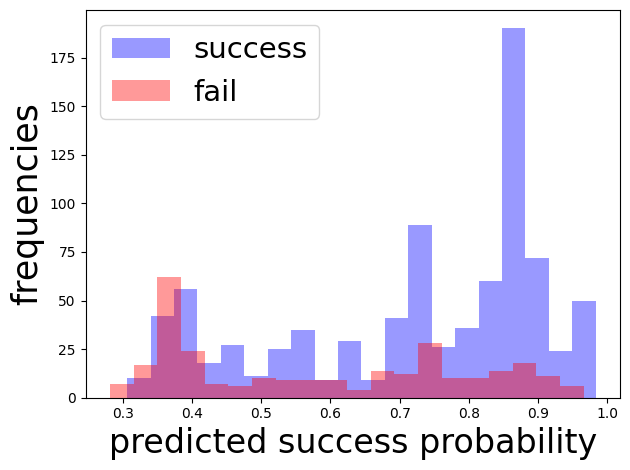

In [7]:
hint_model_path = "save_model/" + base_name + ".ckpt"
if not os.path.exists(hint_model_path):
	model = HINTModel(molecule_encoder = mpnn_model, 
			disease_encoder = gram_model, 
			protocol_encoder = protocol_model,
			device = device, 
			global_embed_size = 50, 
			highway_num_layer = 2,
			prefix_name = base_name, 
			gnn_hidden_size = 50,  
			epoch = 15,
			lr = 5e-4, 
			weight_decay = 1e-3, 
			)
	model.init_pretrain(admet_model)
	train_output, valid_output = model.learn(train_loader, valid_loader, test_loader)
	nctid_all, predict_all = model.bootstrap_test(test_loader, valid_loader=valid_loader)
	torch.save(model, hint_model_path)
else:
	model = torch.load(hint_model_path)
	model.bootstrap_test(test_loader)
	train_loss, train_predict, train_label = model.test(train_loader, return_loss=True)
	test_loss, test_predict, test_label = model.test(test_loader, return_loss=True)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [9]:
n = len(test_predict)
test_predict_label = [0] * n
for i in range(n):
    if test_predict[i] > 0.5:
        test_predict_label[i] = 1

accuracy_score(test_predict_label, test_label)

0.7190226876090751

In [10]:
n = len(train_predict)
train_predict_label = [0] * n
for i in range(n):
    if train_predict[i] > 0.5:
        train_predict_label[i] = 1

accuracy_score(train_predict_label, train_label)
# len(test_label)
# sum(test_label) / len(test_label)


0.7527472527472527

In [11]:
n = len(test_predict)
test_predict_label = [0] * n
for i in range(n):
    if test_predict[i] > 0.5:
        test_predict_label[i] = 1

accuracy_score(test_predict_label, test_label)
# len(test_label)
sum(test_label) / len(test_label)
sum(test_predict) / len(test_predict)
len(test_predict)
# plt.hist(test_predict)

1146

In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.optimize import brentq
from scipy.stats import binom
import seaborn as sns
from copy import deepcopy 

In [24]:
smx = np.array(train_predict)
labels = np.array(train_label)
# smx = np.array(test_predict)
# labels = np.array(test_label)
a = 1-smx
smx = np.vstack((a, smx))
smx = smx.transpose()
smx.shape

(3094, 2)

In [25]:
labels.sum() / len(labels)

0.6531997414350356

In [26]:
n = 300
alpha = 0.1
delta = 0.1


In [44]:
lambdas = np.linspace(0,1,501)
prauc = []
f1 = []
rocauc = []
selective_accuracy = []
improved_accuracy = []
points_kept = []

for i in range(20):
    # Split the softmax scores into calibration and validation sets (save the shuffling)
    idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
    np.random.shuffle(idx)
    cal_smx, val_smx = smx[idx,:], smx[~idx,:]
    cal_labels, val_labels = labels[idx], labels[~idx]
    # Yhat, Phat
    cal_yhats = np.argmax(cal_smx, axis=1); val_yhats = np.argmax(val_smx, axis=1)
    cal_phats = np.max(cal_smx, axis=1); val_phats = np.max(val_smx, axis=1)


    # Define selective risk
    def selective_risk(lam): 
        return (cal_yhats[cal_phats >= lam] != cal_labels[cal_phats >= lam]).sum()/(cal_phats >= lam).sum()
    def nlambda(lam): 
        return (cal_phats > lam).sum()
    def invert_for_ub(r,lam): 
        return binom.cdf(selective_risk(lam)*nlambda(lam),nlambda(lam),r)-delta
    # Construct upper boud
    def selective_risk_ub(lam): 
        return brentq(invert_for_ub,0.1,0.9999,args=(lam,))
    # Make sure there's some data in the top bin.
    lambdas = np.array([lam for lam in lambdas if nlambda(lam) >= 200]) 
    # Scan to choose lamabda hat
    for lhat in np.flip(lambdas):
        # print(lhat)
        print(lhat, selective_risk_ub(lhat-1/lambdas.shape[0]), selective_risk_ub(lhat-1/lambdas.shape[0]) > alpha)
        if selective_risk_ub(lhat-1/lambdas.shape[0]) > alpha: break
    # Deploy procedure on test data
    predictions_kept = val_phats >= lhat


    from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score, accuracy_score
    # Calculate empirical selective accuracy

    test_accuracy = accuracy_score(test_predict_label, test_label)
    empirical_selective_accuracy = (val_yhats[predictions_kept] == val_labels[predictions_kept]).mean()
    empirical_improved_accuracy = empirical_selective_accuracy - test_accuracy
    fraction_kept = predictions_kept.mean()

    val_label_kept = val_labels[predictions_kept]
    val_pred_kept = val_yhats[predictions_kept]
    val_score_kept = val_smx[:,1][predictions_kept]

    prauc_score = average_precision_score(val_label_kept, val_score_kept)
    f1score = f1_score(val_label_kept, val_pred_kept)
    auc_score = roc_auc_score(val_label_kept, val_score_kept)
    precision = precision_score(val_label_kept, val_pred_kept)
    recall = recall_score(val_label_kept, val_pred_kept)
    accuracy = accuracy_score(val_label_kept, val_pred_kept)
    predict_1_ratio = sum(val_pred_kept) / len(val_pred_kept)
    label_1_ratio = sum(val_label_kept) / len(val_label_kept)

    prauc.append(prauc_score)
    f1.append(f1score)
    rocauc.append(auc_score)
    selective_accuracy.append(empirical_selective_accuracy)
    improved_accuracy.append(empirical_improved_accuracy)
    points_kept.append(fraction_kept)

print(f"The original accuracy is:\t\t{test_accuracy:.4F}")
print(f"The empirical selective accuracy is:\tmean: {np.mean(selective_accuracy):.4F}\tstd: {np.std(selective_accuracy):.4f}")
print(f"The empirical improved accuracy is:\tmean: {np.mean(improved_accuracy):.4F}\tstd: {np.std(improved_accuracy):.4f}")
print(f"The fraction of data points kept is:\tmean: {np.mean(points_kept):.4F}\tstd: {np.std(points_kept):.4f}")

print(f"PR_AUC\t mean: {np.mean(prauc):.4F}\tstd: {np.std(prauc):.4f}")
print(f"F1\t mean: {np.mean(f1):.4F}\tstd: {np.std(f1):.4f}")
print(f"ROC_AUC  mean: {np.mean(rocauc):.4F}\tstd: {np.std(rocauc):.4f}")


0.642 0.17860440631727212 True
0.642 0.26238383765828205 True
0.63 0.19061346209594612 True
0.63 0.26162067706425035 True
0.63 0.21005796882887037 True
0.63 0.2462501938941015 True
0.63 0.2905119860477021 True
0.63 0.22698011454308886 True
0.63 0.24517324181715394 True
0.63 0.2801399739727102 True
0.63 0.2116061919071585 True
0.63 0.2323093926049816 True
0.628 0.25995106509488775 True
0.628 0.2032176857694741 True
0.628 0.25895669499552676 True
0.628 0.1975279104473505 True
0.628 0.21762764648463054 True
0.628 0.29260361161843557 True
0.628 0.2675767602279733 True
0.628 0.24263714351242657 True
The original accuracy is:		0.7190
The empirical selective accuracy is:	mean: 0.8122	std: 0.0059
The empirical improved accuracy is:	mean: 0.0932	std: 0.0059
The fraction of data points kept is:	mean: 0.7117	std: 0.0172
PR_AUC	 mean: 0.9022	std: 0.0031
F1	 mean: 0.8857	std: 0.0048
ROC_AUC  mean: 0.7735	std: 0.0077


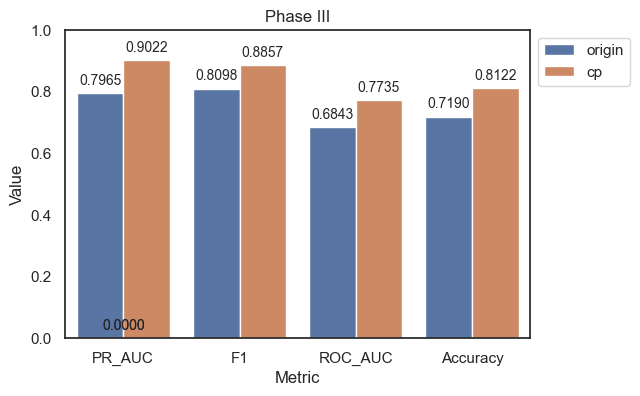

In [45]:
# PR-AUC   mean: 0.7965 std: 0.0092
# F1       mean: 0.8098 std: 0.0093
# ROC-AUC  mean: 0.6843 std: 0.0220

import matplotlib.pyplot as plt
import seaborn as sns

origin = [0.7965, 0.8098, 0.6843, accuracy_score(test_predict_label, test_label)]
cp = [np.mean(prauc), np.mean(f1), np.mean(rocauc), np.mean(selective_accuracy)]
sns.set(style='white')

# X axis
X_labels = ["PR_AUC", "F1", "ROC_AUC", "Accuracy"]

import pandas as pd

data = {
    'Metric': X_labels * 2,  
    'Value': origin + cp,  
    'Type': ['origin']*4 + ['cp']*4  
}

df = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Metric', y='Value', hue='Type', data=df)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize = 10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Phase III')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.ylim(0, 1)

# 显示图形
plt.show()


In [46]:

# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]
# Yhat, Phat
cal_yhats = np.argmax(cal_smx, axis=1); val_yhats = np.argmax(val_smx, axis=1)
cal_phats = np.max(cal_smx, axis=1); val_phats = np.max(val_smx, axis=1)

# Define selective risk
def selective_risk(lam): 
    return (cal_yhats[cal_phats >= lam] != cal_labels[cal_phats >= lam]).sum()/(cal_phats >= lam).sum()
def nlambda(lam): 
    return (cal_phats > lam).sum()
def invert_for_ub(r,lam): 
    return binom.cdf(selective_risk(lam)*nlambda(lam),nlambda(lam),r)-delta
# Construct upper boud
def selective_risk_ub(lam): 
    return brentq(invert_for_ub,0,0.9999,args=(lam,))
# Make sure there's some data in the top bin.
lambdas = np.array([lam for lam in lambdas if nlambda(lam) >= 200]) 
# Scan to choose lamabda hat
for lhat in np.flip(lambdas):
    if selective_risk_ub(lhat-1/lambdas.shape[0]) > alpha: break
# Deploy procedure on test data
predictions_kept = val_phats >= lhat
sum(predictions_kept)
len(predictions_kept)
lhat

0.628

In [47]:
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score, accuracy_score
# Calculate empirical selective accuracy

test_accuracy = accuracy_score(test_predict_label, test_label)
print(f"The original accuracy is:\t\t{test_accuracy:.4F}")
empirical_selective_accuracy = (val_yhats[predictions_kept] == val_labels[predictions_kept]).mean()
print(f"The empirical selective accuracy is:\t{empirical_selective_accuracy:.4F}")
improved_accuracy = empirical_selective_accuracy - test_accuracy
print(f"The improved accuracy is:\t\t{improved_accuracy:.4F}")
# false_flags = (val_yhats[~predictions_kept] == val_labels[~predictions_kept]).mean()
# print(f"The fraction of false flags is:\t\t{false_flags:.4F}")
fraction_kept = predictions_kept.mean()
print(f"The fraction of data points kept is:\t{fraction_kept:.4F}")

val_label_kept = val_labels[predictions_kept]
val_pred_kept = val_yhats[predictions_kept]
val_score_kept = val_smx[:,1][predictions_kept]

prauc_score = average_precision_score(val_label_kept, val_score_kept)
print(f"PR_AUC:\t\t{prauc_score:.4F}")
f1score = f1_score(val_label_kept, val_pred_kept)
print(f"F1:\t\t{f1score:.4F}")
auc_score = roc_auc_score(val_label_kept, val_score_kept)
print(f"ROC_AUC:\t{auc_score:.4F}")

precision = precision_score(val_label_kept, val_pred_kept)
print(f"precision:\t{precision:.4F}")
recall = recall_score(val_label_kept, val_pred_kept)
print(f"recall:\t\t{recall:.4F}")
accuracy = accuracy_score(val_label_kept, val_pred_kept)
print(f"accuracy:\t{accuracy:.4F}")
predict_1_ratio = sum(val_pred_kept) / len(val_pred_kept)
print(f"pred_1_ratio:\t{predict_1_ratio:.4F}")
label_1_ratio = sum(val_label_kept) / len(val_label_kept)
print(f"label_1_ratio:\t{label_1_ratio:.4F}")


The original accuracy is:		0.7190
The empirical selective accuracy is:	0.8089
The improved accuracy is:		0.0899
The fraction of data points kept is:	0.7212
PR_AUC:		0.8991
F1:		0.8822
ROC_AUC:	0.7784
precision:	0.8198
recall:		0.9550
accuracy:	0.8089
pred_1_ratio:	0.8730
label_1_ratio:	0.7494


In [48]:
import pandas as pd

train_csv = pd.read_csv(test_file, delimiter=',')
nctids = list(train_csv['nctid'])

_ncts = []
_keeps = []
_yhats = []
_labels = []
_smx = []

for i in range(10):
    rand_nct = np.random.choice(nctids)
    _ncts.append(rand_nct)
    # print(rand_nct, nctids.index(rand_nct))
    idx = nctids.index(rand_nct)
    _smx.append(smx[idx][1])
    _keeps.append(np.max(smx[idx]) >= lhat)
    _yhats.append([np.argmax(smx[idx])])
    _labels.append(labels[idx])

for i in range(len(_ncts)):
    print(f"nctid: {rand_nct} | Probability: {_smx[i]:.4f} | Prediction: {_yhats[i][0]} | Label: {_labels[i]} | Abstained: {~_keeps[i]}")


nctid: NCT02951052 | Probability: 0.8353 | Prediction: 1 | Label: 1 | Abstained: False
nctid: NCT02951052 | Probability: 0.9183 | Prediction: 1 | Label: 1 | Abstained: False
nctid: NCT02951052 | Probability: 0.5626 | Prediction: 1 | Label: 1 | Abstained: True
nctid: NCT02951052 | Probability: 0.5978 | Prediction: 1 | Label: 1 | Abstained: True
nctid: NCT02951052 | Probability: 0.8216 | Prediction: 1 | Label: 1 | Abstained: False
nctid: NCT02951052 | Probability: 0.3973 | Prediction: 0 | Label: 0 | Abstained: True
nctid: NCT02951052 | Probability: 0.8219 | Prediction: 1 | Label: 0 | Abstained: False
nctid: NCT02951052 | Probability: 0.9121 | Prediction: 1 | Label: 1 | Abstained: False
nctid: NCT02951052 | Probability: 0.3410 | Prediction: 0 | Label: 0 | Abstained: False
nctid: NCT02951052 | Probability: 0.8810 | Prediction: 1 | Label: 1 | Abstained: False


In [49]:
def selective_risk2(lam): 
    return (val_yhats[val_phats >= lam] != val_labels[val_phats >= lam]).sum()/(val_phats >= lam).sum()

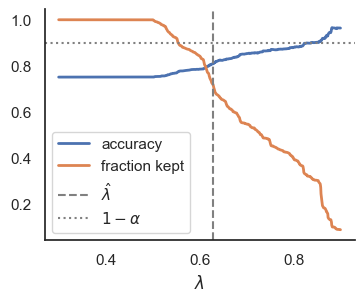

In [50]:
import seaborn as sns

lambdas = np.linspace(0.3,0.9,1000)
sns.set(style='white')
selective_accuracy_curve = [1-selective_risk2(lam) for lam in lambdas]
fraction_kept_curve = [(val_phats >= lam).mean() for lam in lambdas]
fig, axs = plt.subplots(1,1,figsize=(4,3))
axs.plot(lambdas,selective_accuracy_curve,label='accuracy',linewidth=2)
axs.plot(lambdas,fraction_kept_curve,label='fraction kept',linewidth=2)
axs.axvline(x=lhat,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}$',color='gray')
axs.axhline(y=1-alpha,linewidth=1.5,linestyle='dotted',label=r'$1-\alpha$',color='gray')
sns.despine(ax=axs,top=True,right=True)
axs.legend(loc='lower left')
axs.set_xlabel(r'$\lambda$')
plt.show()

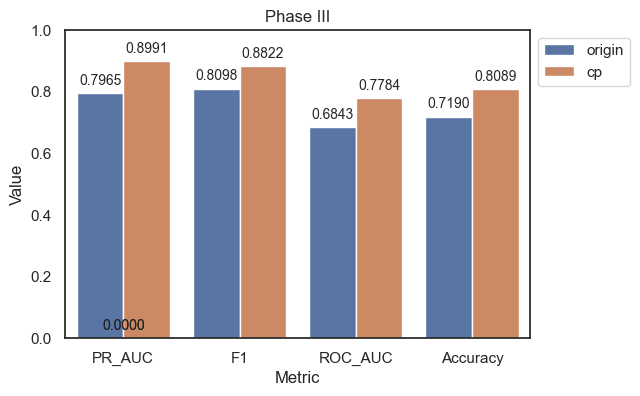

In [51]:
# PR-AUC   mean: 0.7965 std: 0.0092
# F1       mean: 0.8098 std: 0.0093
# ROC-AUC  mean: 0.6843 std: 0.0220

import matplotlib.pyplot as plt
import seaborn as sns

origin = [0.7965, 0.8098, 0.6843, accuracy_score(test_predict_label, test_label)]
cp = [prauc_score, f1score, auc_score, empirical_selective_accuracy]

# X axis
X_labels = ["PR_AUC", "F1", "ROC_AUC", "Accuracy"]

import pandas as pd

data = {
    'Metric': X_labels * 2,  
    'Value': origin + cp,  
    'Type': ['origin']*4 + ['cp']*4  
}

df = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Metric', y='Value', hue='Type', data=df)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize = 10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Phase III')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.ylim(0, 1)

# 显示图形
plt.show()
